# Demand forecasting with the Temporal Fusion Transformer

In [1]:
import copy
import pickle
from pathlib import Path
import warnings
import os
warnings.filterwarnings("ignore")  # avoid printing out absolute paths
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

2022-11-26 12:11:56.115736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 12:11:56.354048: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-26 12:11:57.051259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-26 12:11:57.051352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Load data

In [2]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [6]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


### Create dataset and dataloaders

In [4]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Create baseline model

In [5]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

## Train the Temporal Fusion Transformer

### Find optimal learning rate

In [38]:
# configure network and trainer
pl.seed_everything(42,workers=True)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=10,
    optimizer="adam"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/home/indranil/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 78.0k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/indranil/Downloads/.lr_find_f763a05b-ea3a-40c6-a26e-5d98cc25993f.ckpt
Restored all states from the checkpoint file at /home/indranil/Downloads/.lr_find_f763a05b-ea3a-40c6-a26e-5d98cc25993f.ckpt


suggested learning rate: 0.0015848931924611139


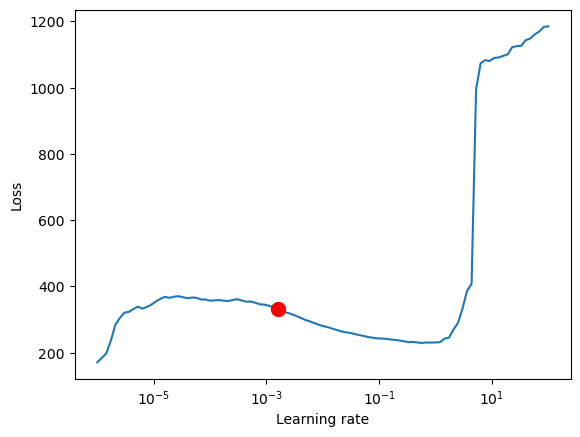

In [40]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=100.0,
    min_lr=1e-6,
    early_stop_threshold=None
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

In [57]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
#early_stop_threshold=None
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    fast_dev_run=False,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    max_steps=10000
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0016,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 78.0k


In [55]:
# fit network
model = trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [69]:
model

In [63]:
# create study
early_stop_threshold=None
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1), #based on the curve grpah mentioned above for learningrate 
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30,max_steps=10000),
    
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder thats me being lazy 
    optimizer="adam"               #setting whihch optimiser to use in 
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-11-26 23:15:47,930] A new study created in memory with name: no-name-fe84adbe-170e-4a89-a5f9-e722575b5520
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2022-11-26 23:18:59,149] Trial 0 finished with value: 159.98716735839844 and parameters: {'gradient_clip_val': 0.5716376802932148, 'hidden_size': 76, 'dropout': 0.28661144376455006, 'hidden_continuous_size': 27, 'attention_head_size': 2, 'learning_rate': 0.029187210663294324}. Best is trial 0 with value: 159.98716735839844.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2022-11-26 23:19:13,377] Trial 1 pruned. Trial was pruned at epoch 1.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 

{'gradient_clip_val': 0.5716376802932148, 'hidden_size': 76, 'dropout': 0.28661144376455006, 'hidden_continuous_size': 27, 'attention_head_size': 2, 'learning_rate': 0.029187210663294324}


In [73]:
study.best_params

{'gradient_clip_val': 0.5716376802932148,
 'hidden_size': 76,
 'dropout': 0.28661144376455006,
 'hidden_continuous_size': 27,
 'attention_head_size': 2,
 'learning_rate': 0.029187210663294324}

with the experiment we have now obtained best values for the mode fitting
{'gradient_clip_val': 0.5716376802932148,
 'hidden_size': 76,
 'dropout': 0.28661144376455006,
 'hidden_continuous_size': 27,
 'attention_head_size': 2,
 'learning_rate': 0.029187210663294324}

In [76]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
#early_stop_threshold=None
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.5716376802932148,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    fast_dev_run=False,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    max_steps=10000,
    accelerator="cpu"
)


best_tft= TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.029187210663294324,
    hidden_size=76,
    attention_head_size=2,
    dropout=0.28661144376455006,
    hidden_continuous_size=27,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 78.0k


In [77]:
trainer.fit(
    best_tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 864   
4  | static_variable_selection          | VariableSelectionNetwork        | 32.8 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 74.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 26.6 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 23.6 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 23.6 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 23.6

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

## Evaluate performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [78]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(273.0965)

In [79]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

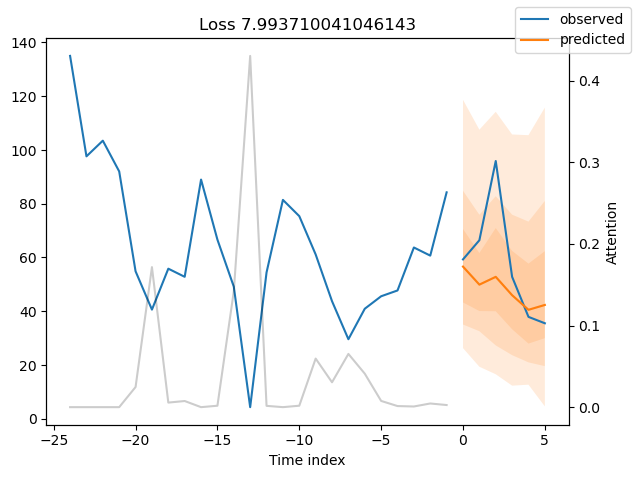

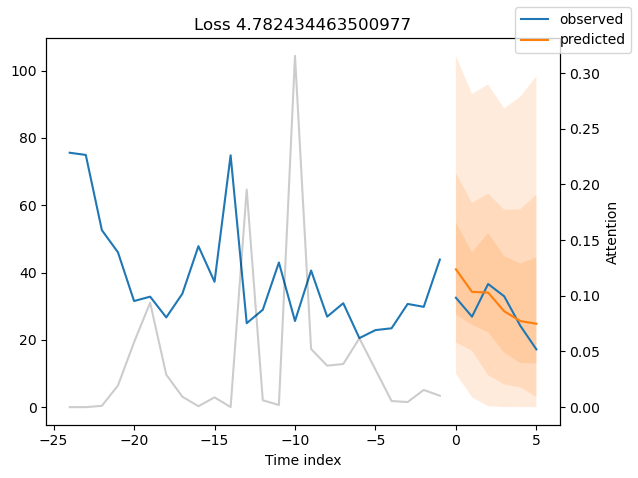

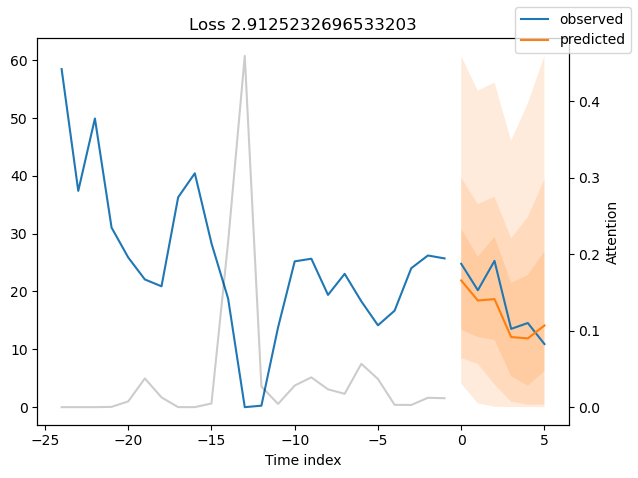

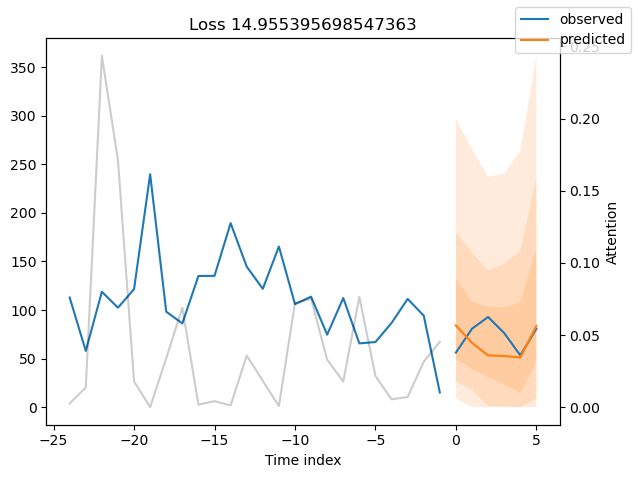

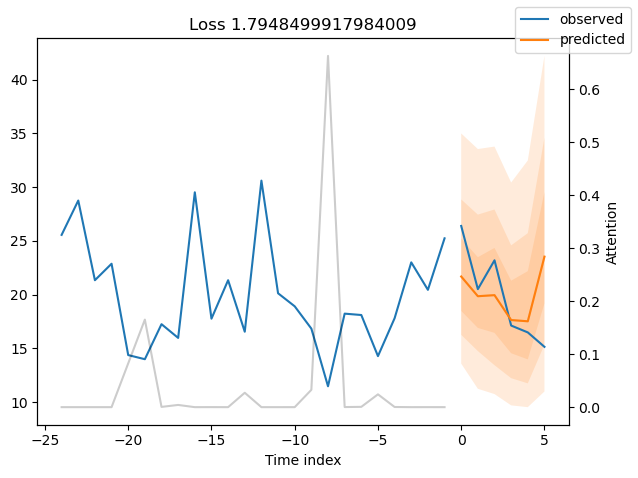

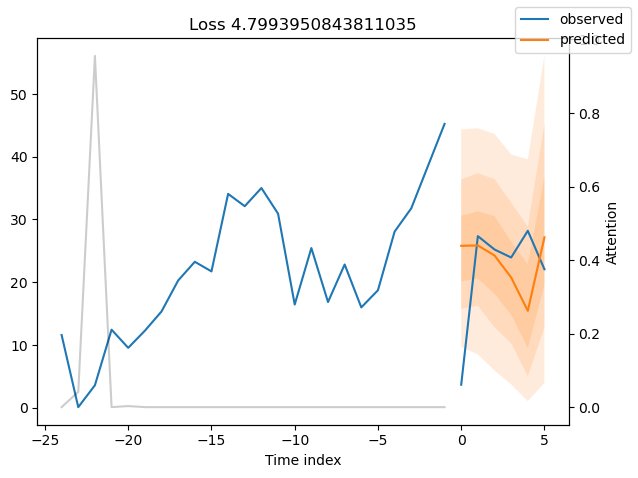

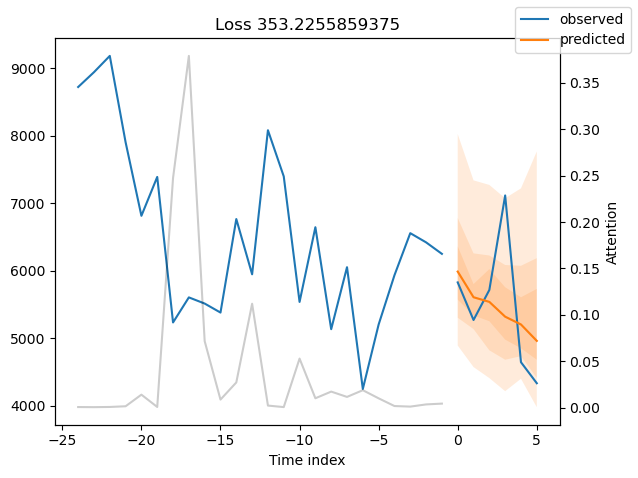

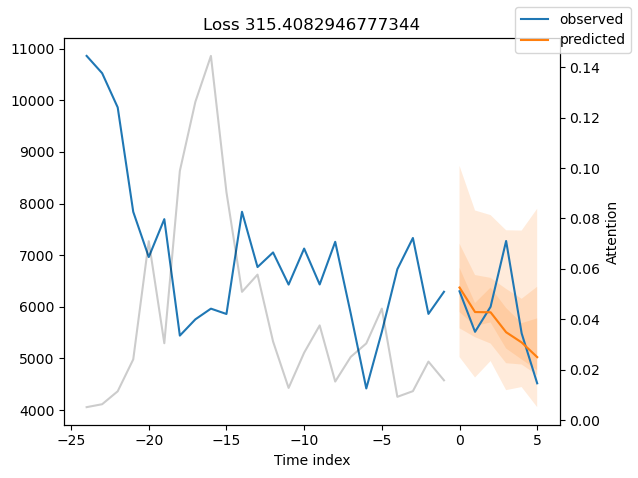

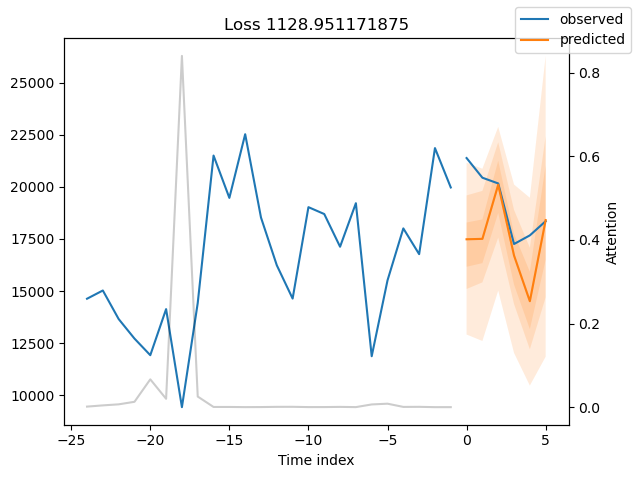

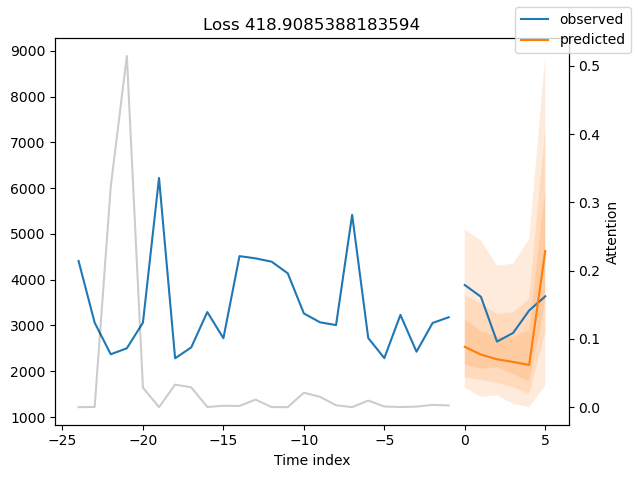

In [80]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Worst performers

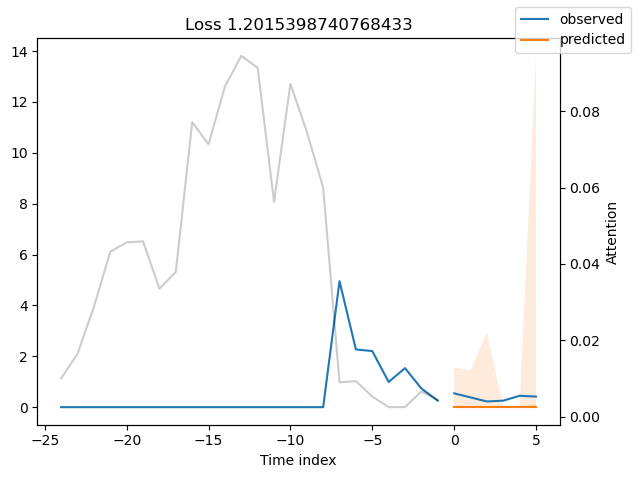

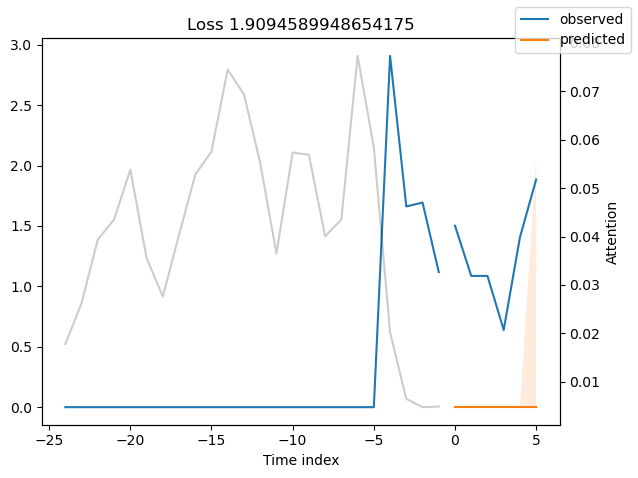

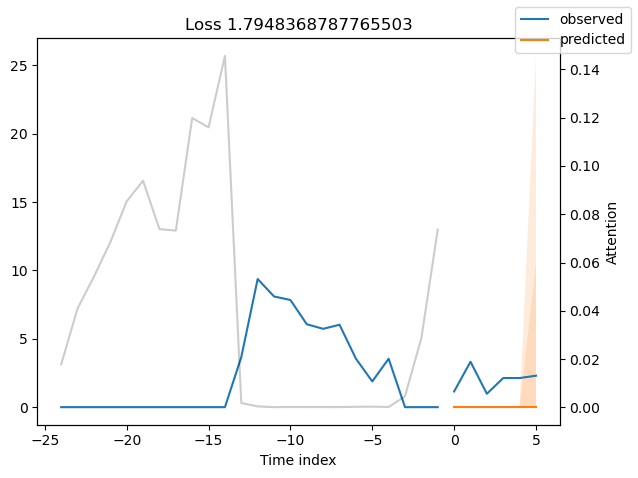

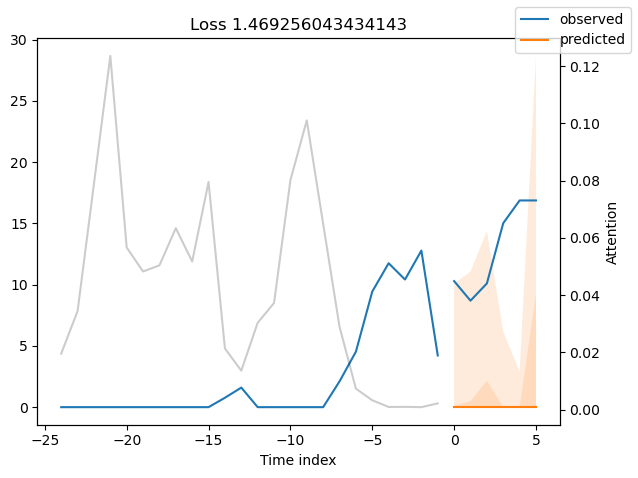

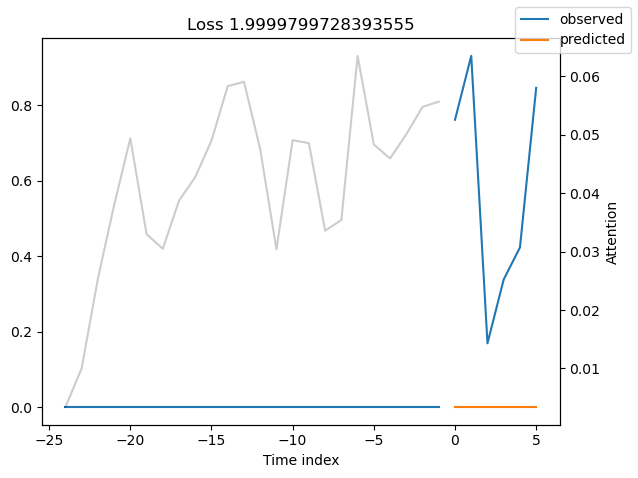

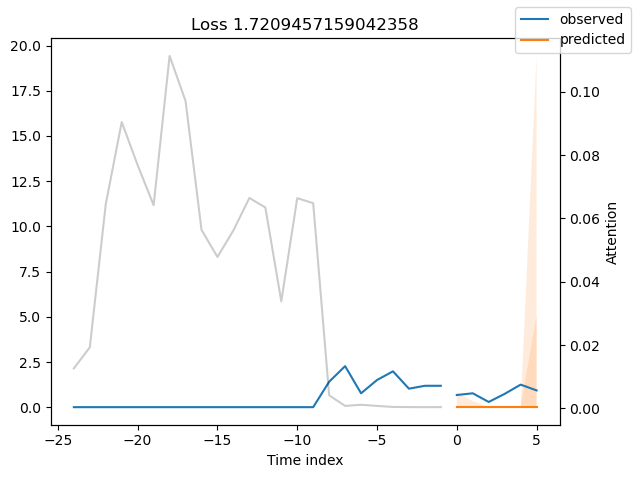

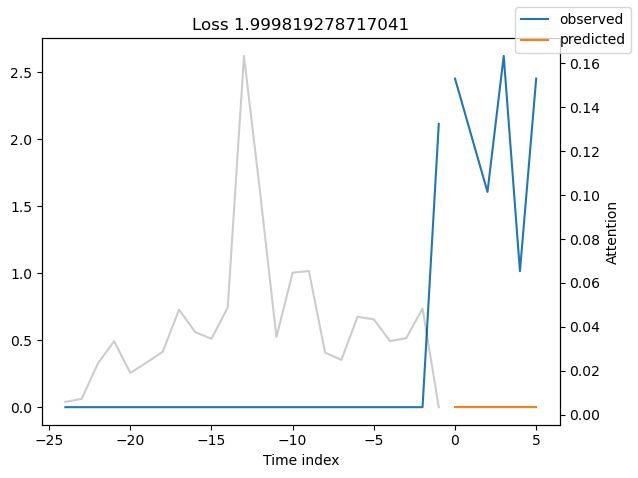

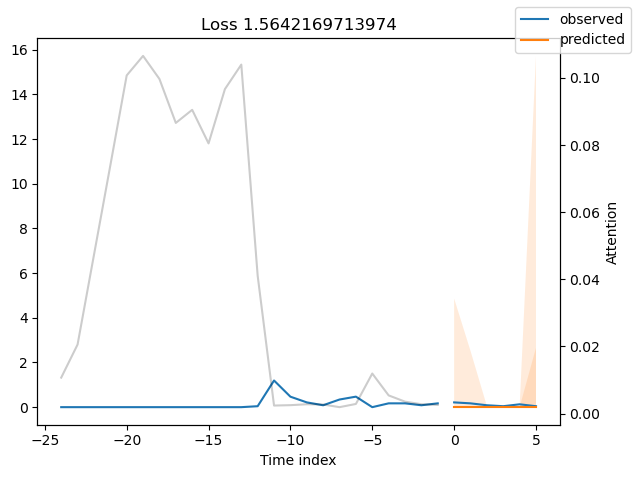

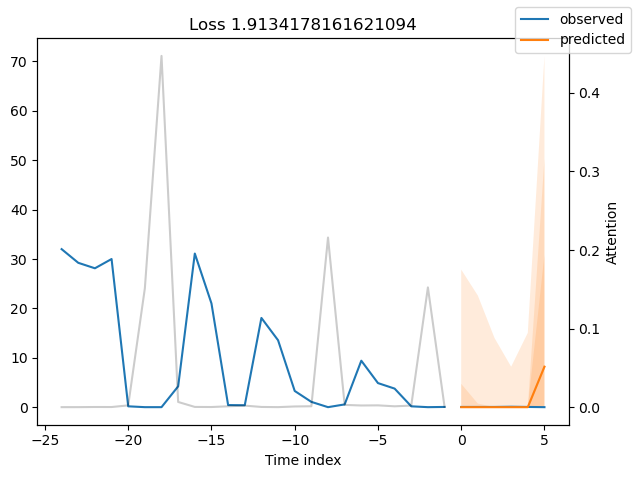

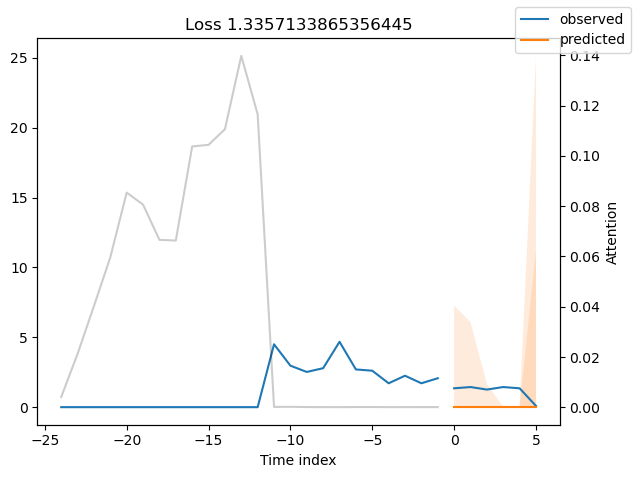

In [81]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

### Actuals vs predictions by variables

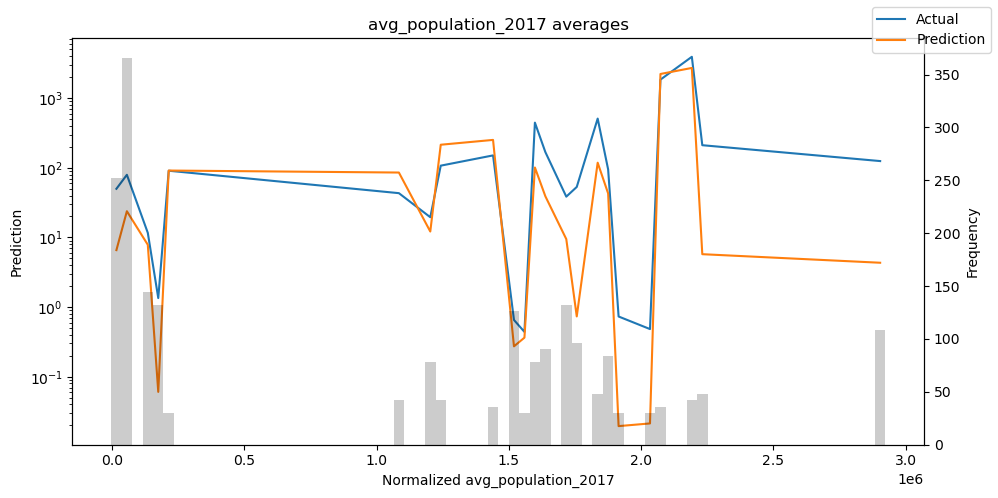

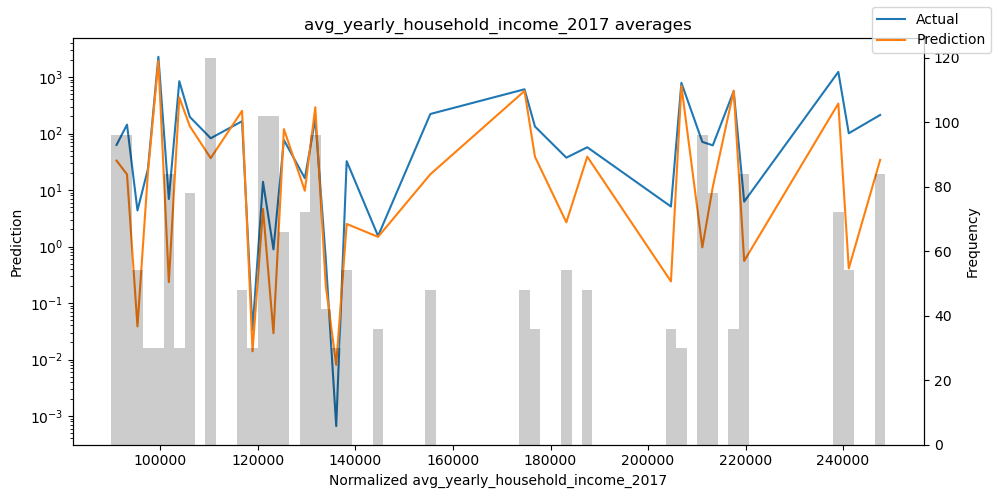

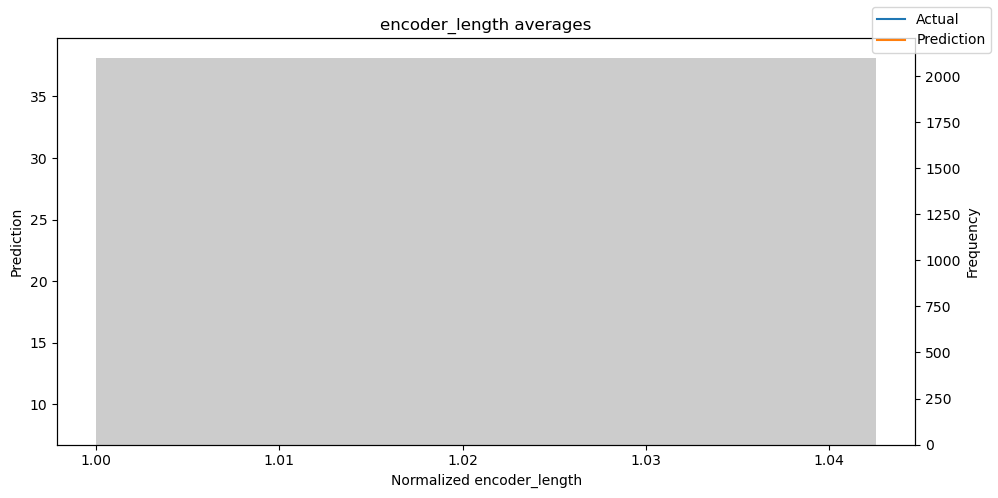

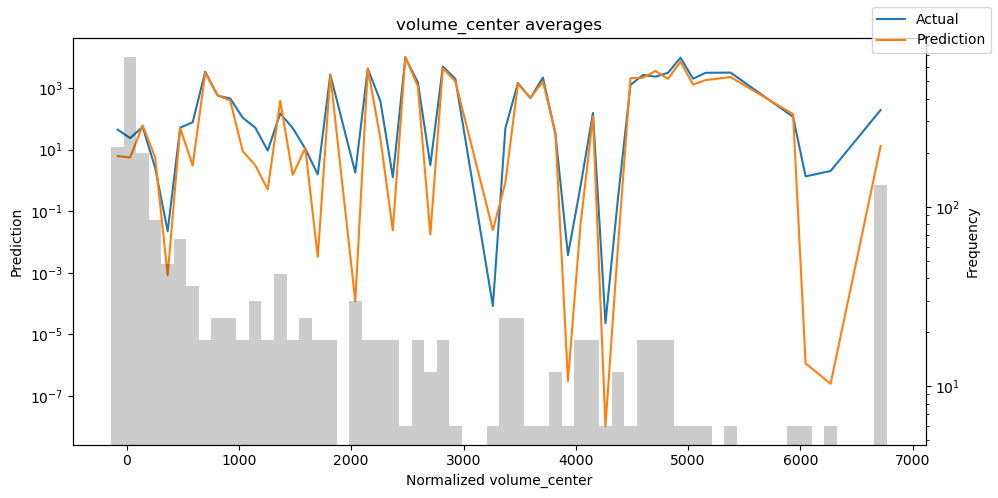

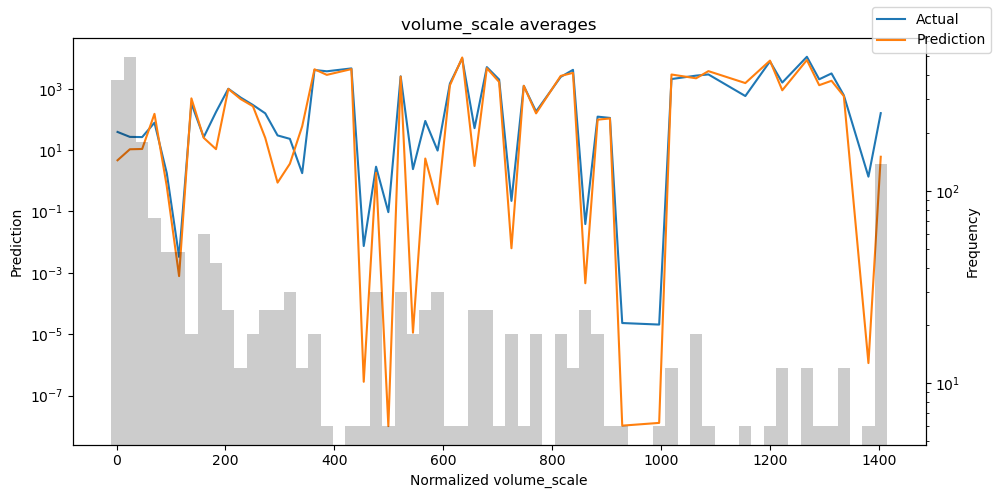

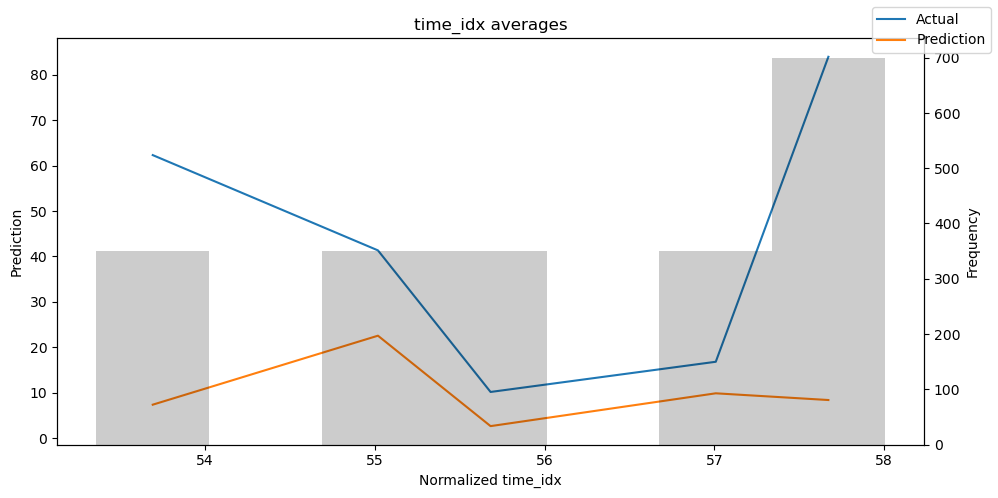

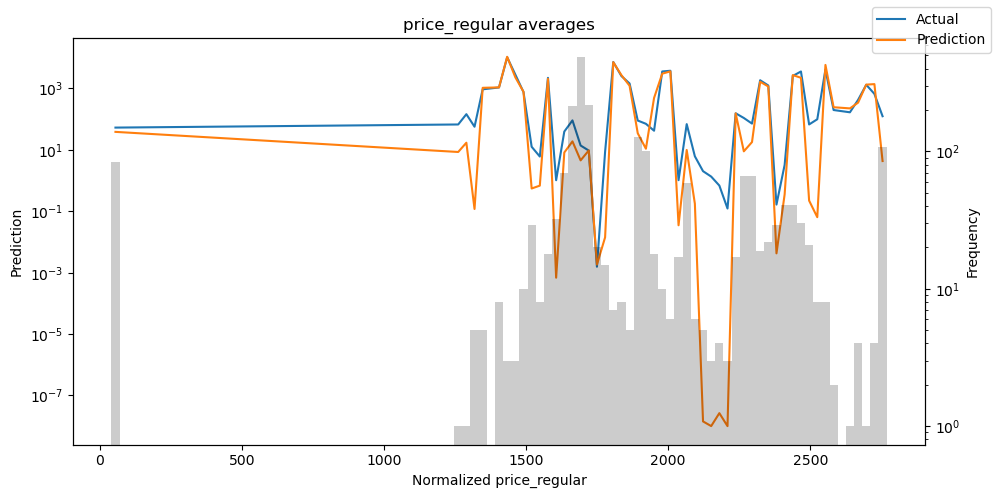

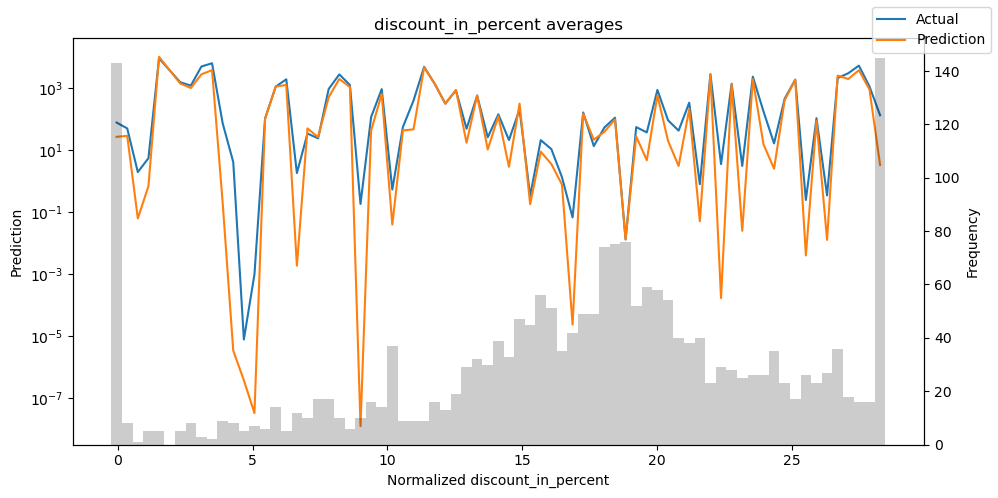

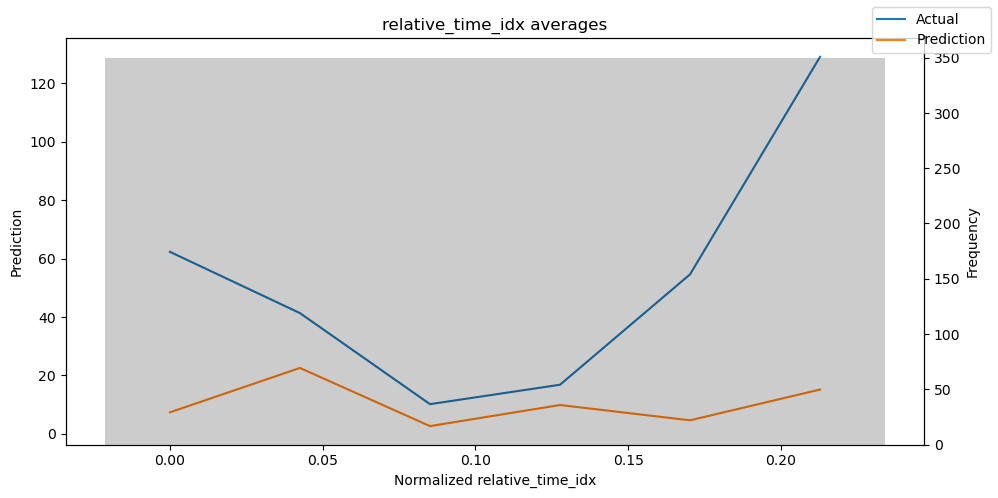

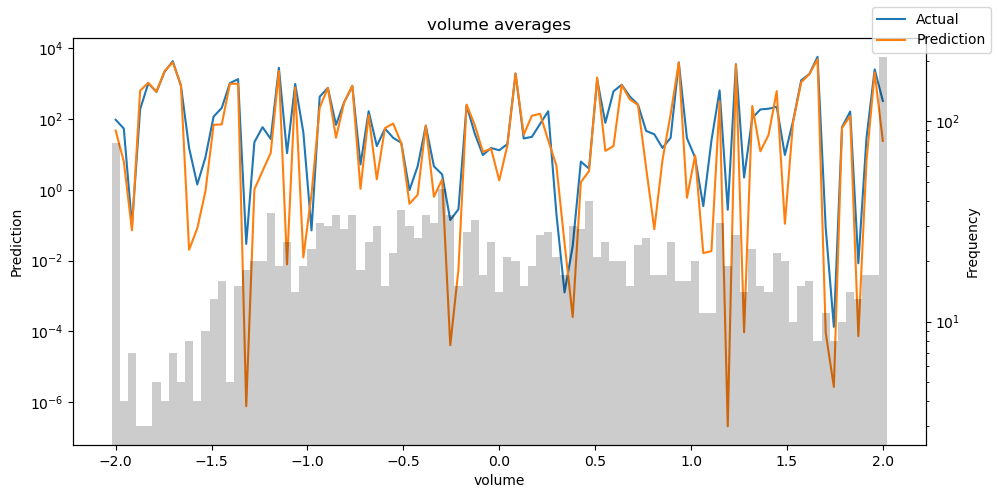

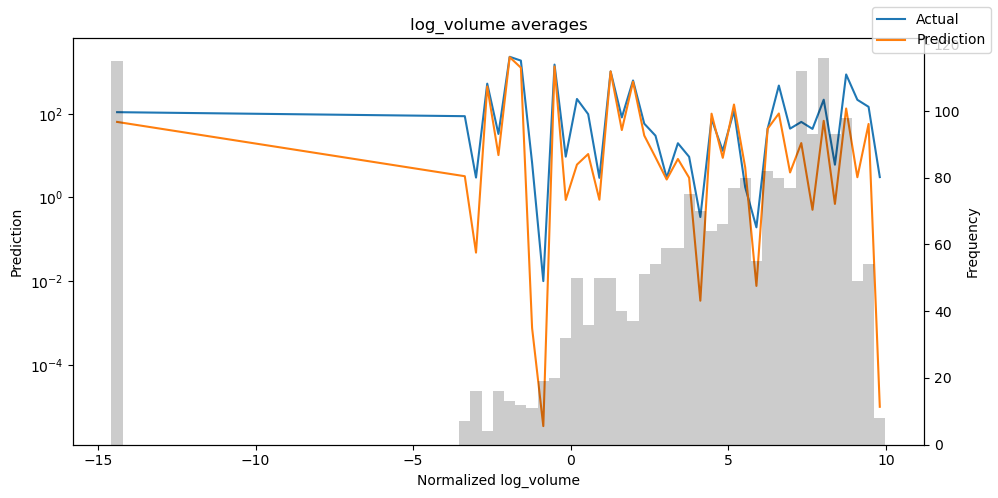

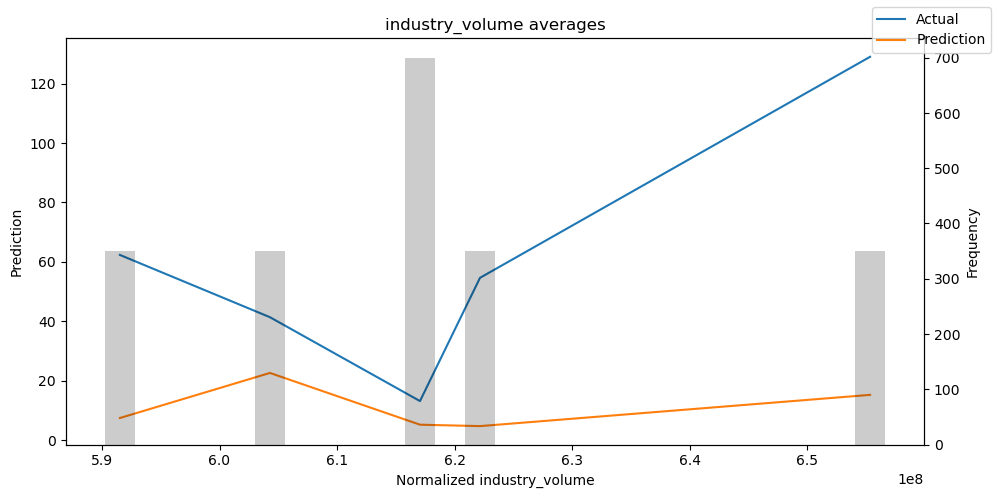

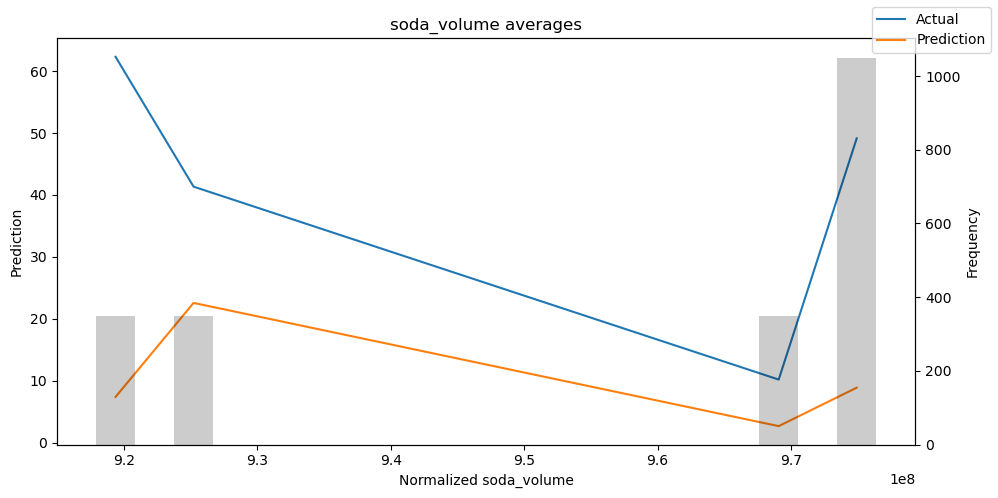

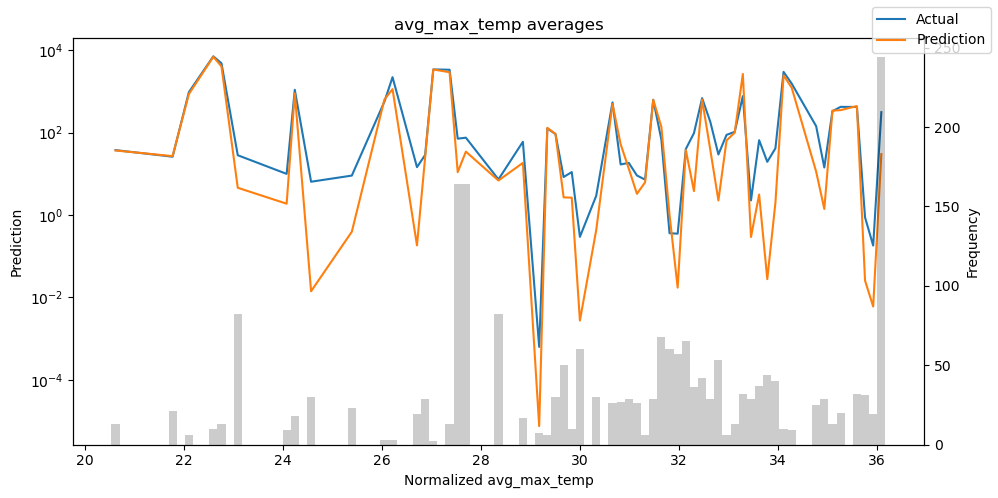

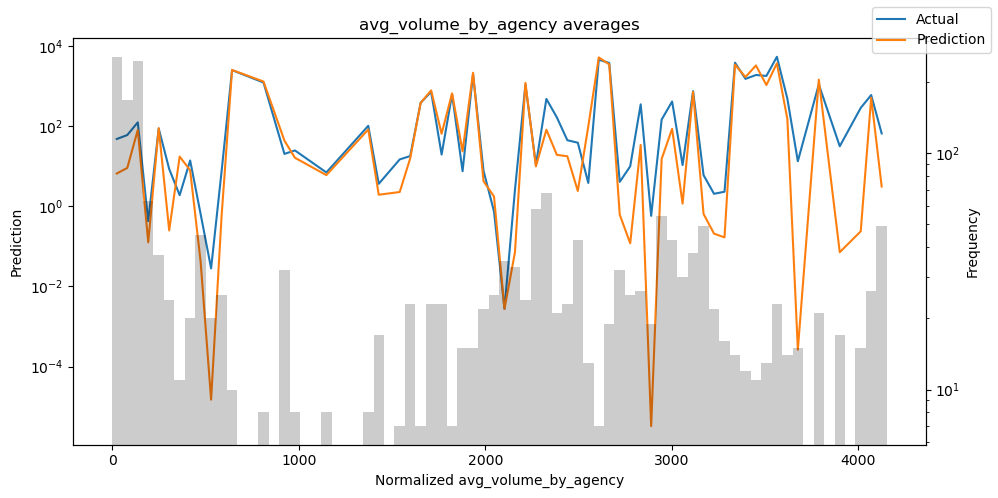

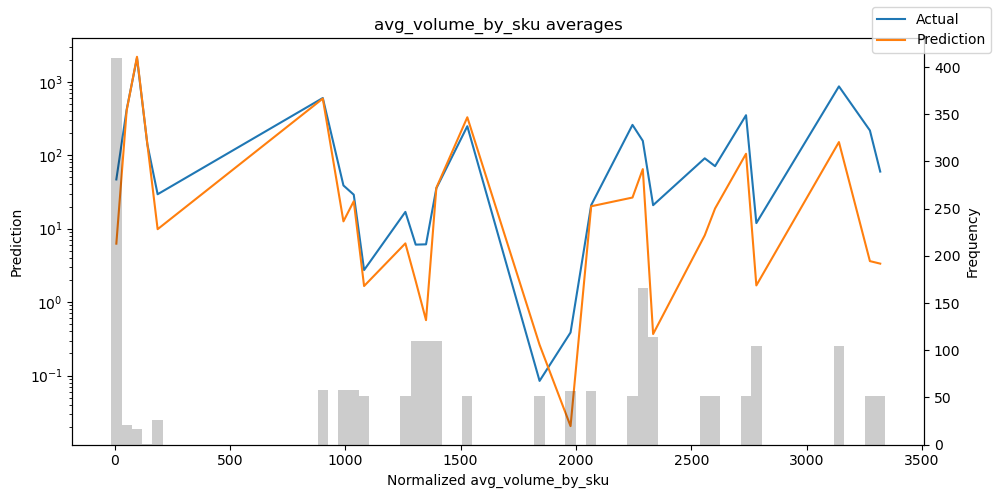

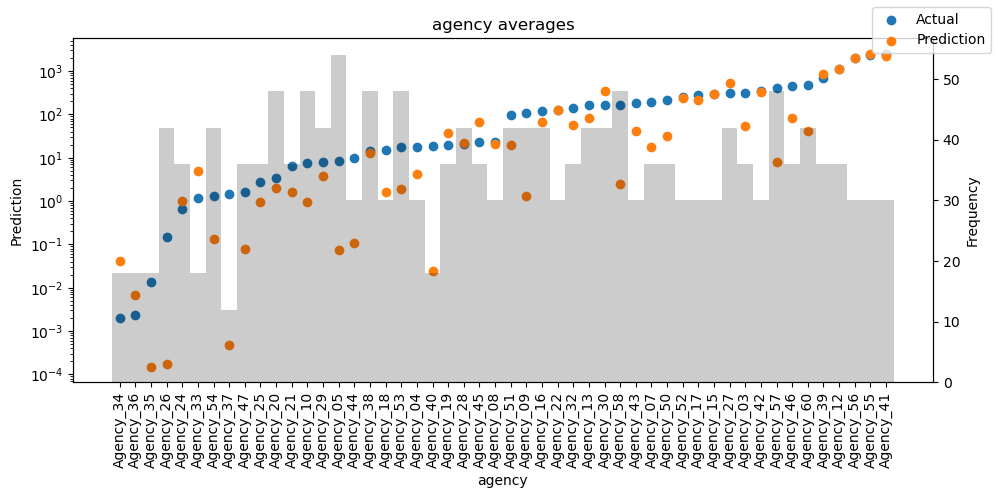

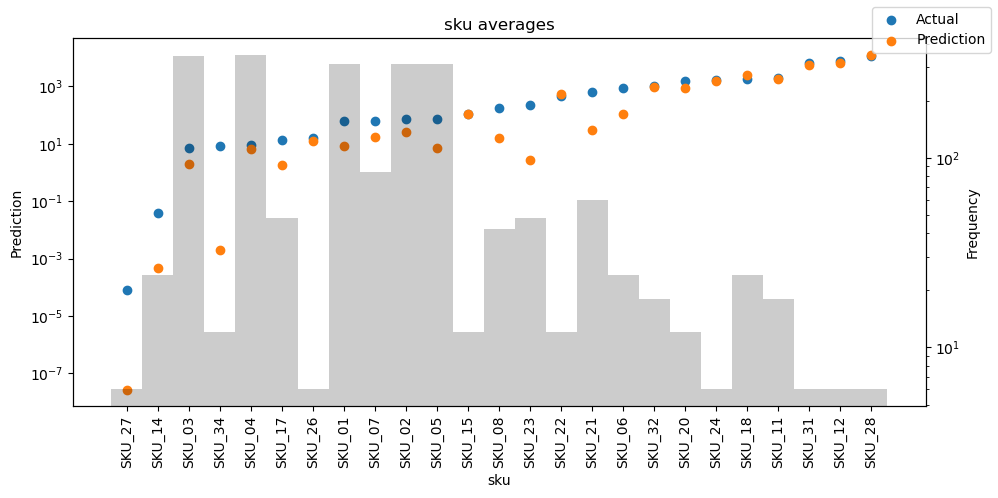

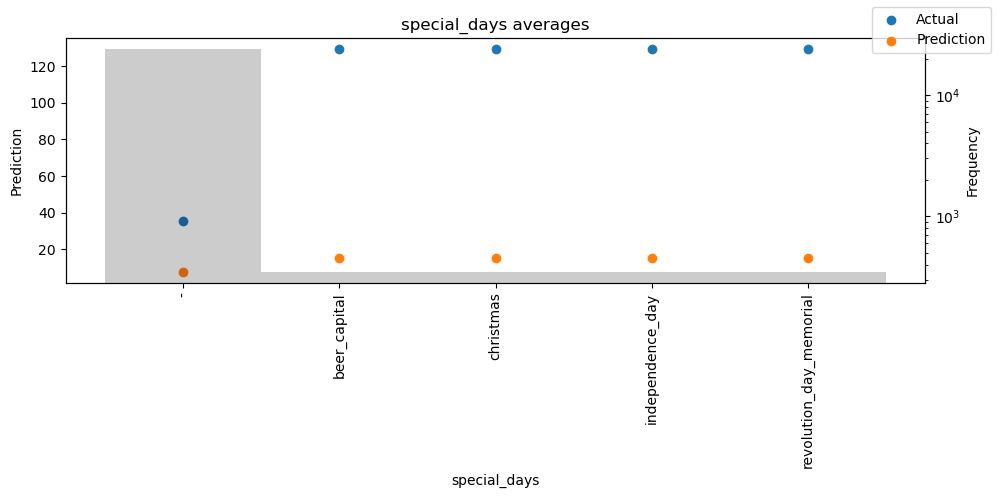

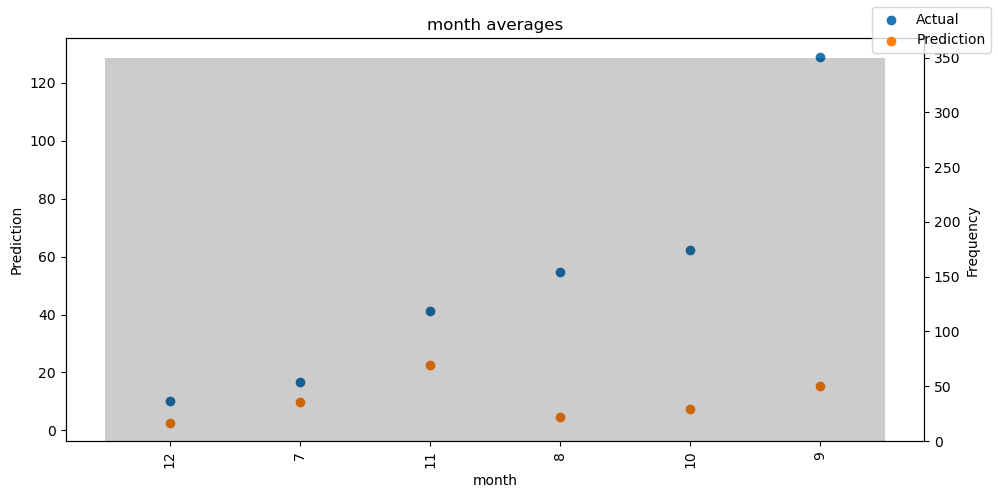

In [82]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Predict on selected data

In [83]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 68.0963,  96.8736, 112.5637, 128.2163, 144.5155, 165.3617, 190.3955],
         [ 52.0717,  80.8217,  98.2574, 117.5150, 140.3770, 164.3073, 195.4492],
         [ 43.8784,  66.5566,  84.7085, 102.9061, 125.2775, 147.1012, 174.6456],
         [ 51.8929,  64.7954,  78.2244,  96.2065, 115.5131, 137.0672, 161.0043],
         [ 49.2614,  68.8049,  83.5436, 100.9874, 120.1137, 144.4361, 167.1562],
         [ 37.3569,  51.7221,  69.1085,  85.0432, 104.2919, 122.1930, 146.3766]]])

Of course, we can also plot this prediction readily:

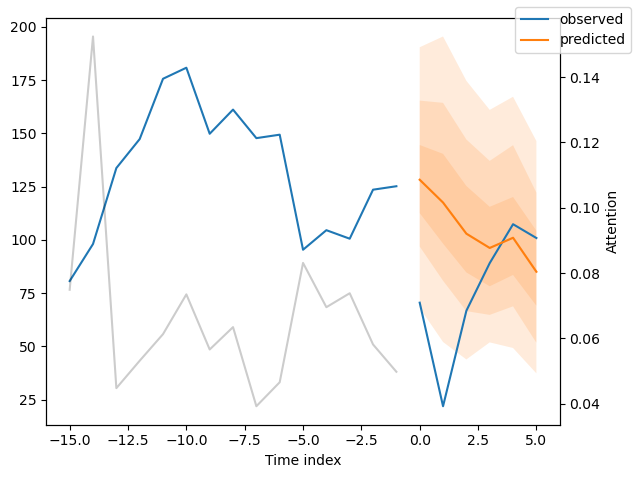

In [84]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

## Predict on new data

Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.

In [85]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

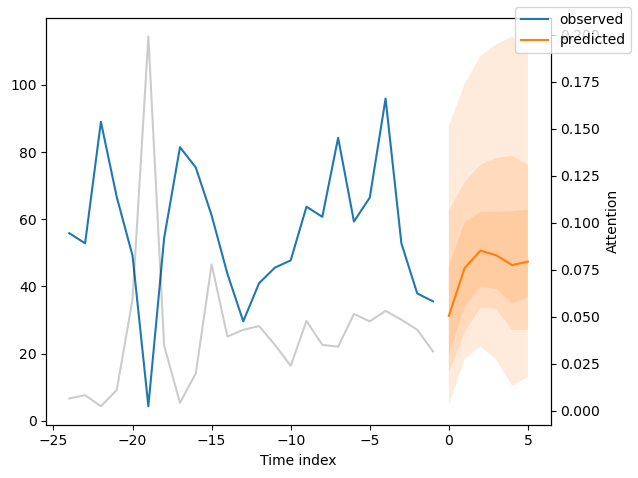

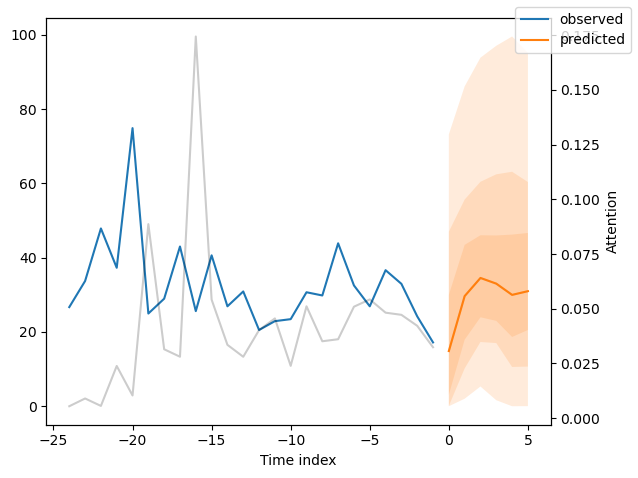

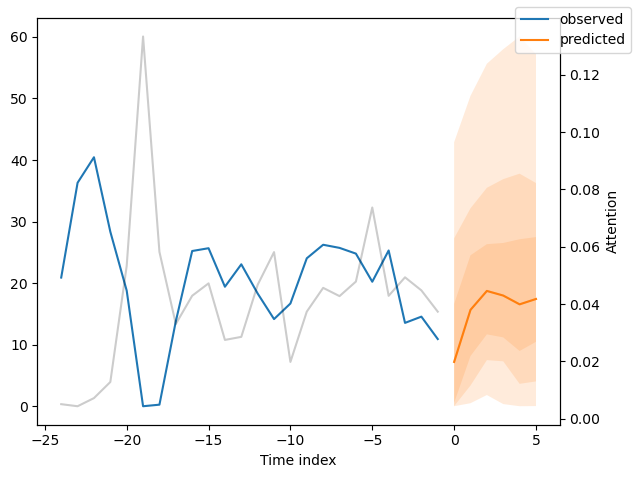

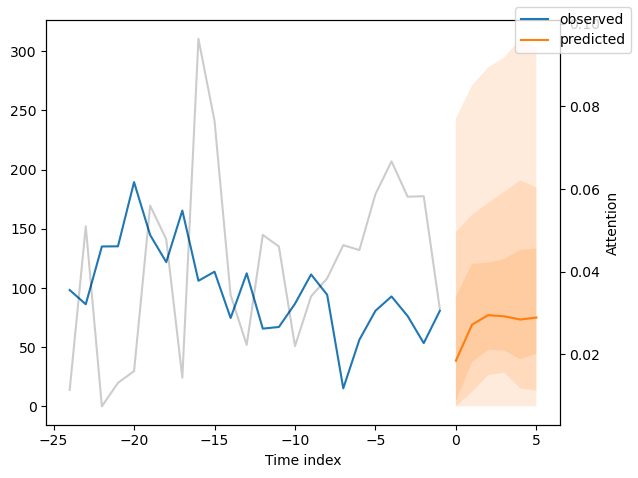

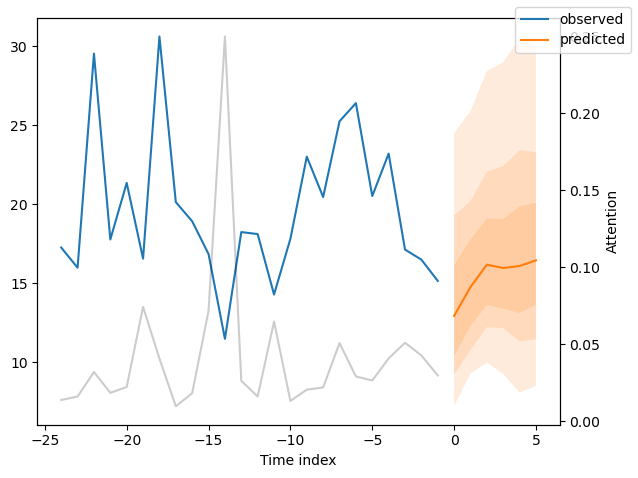

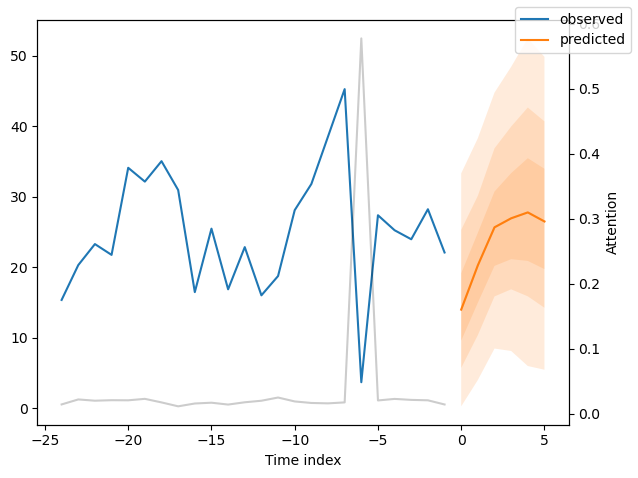

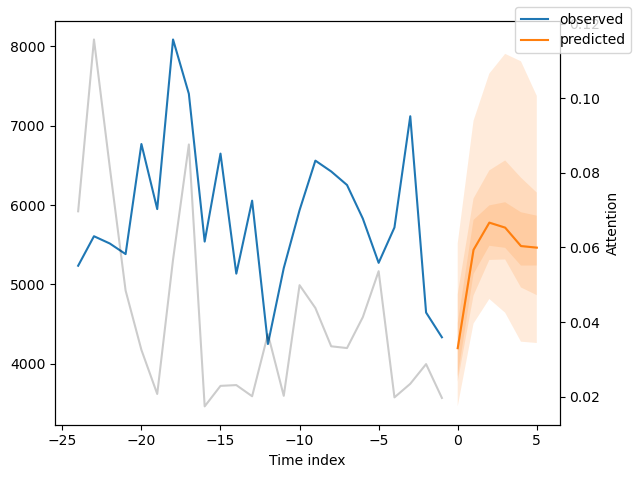

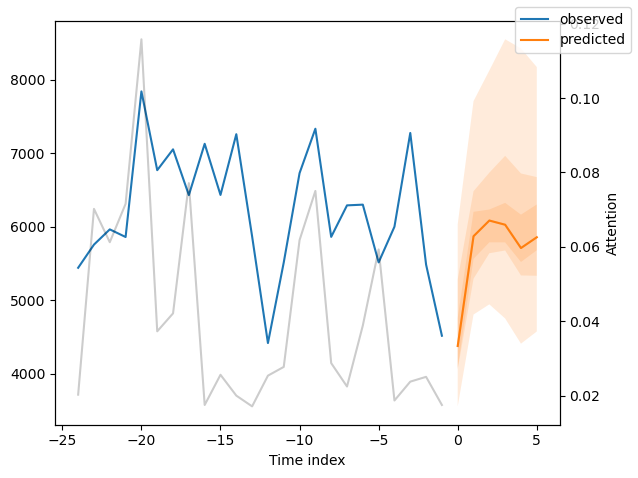

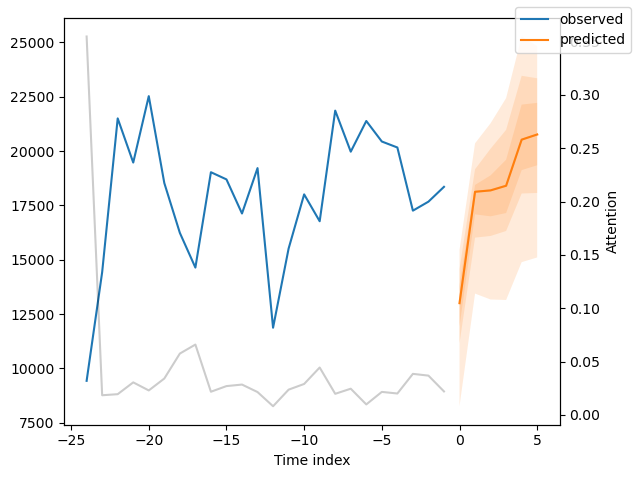

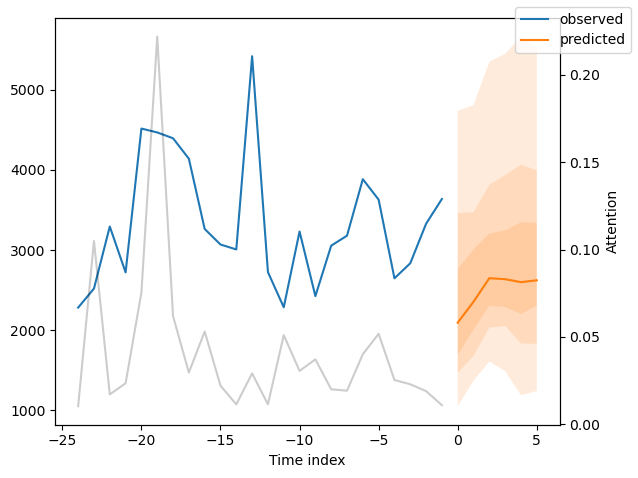

In [86]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

## Interpret model

### Variable importances

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x525 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

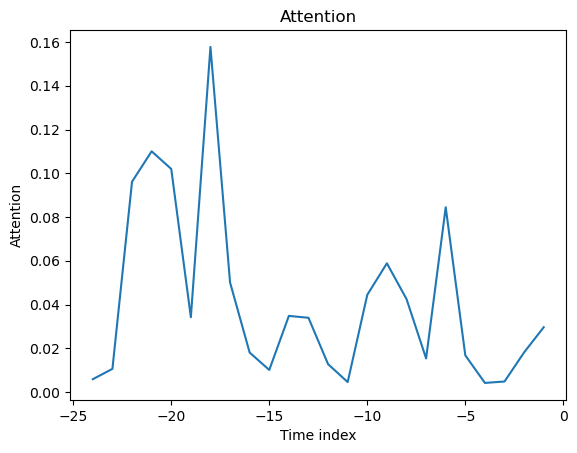

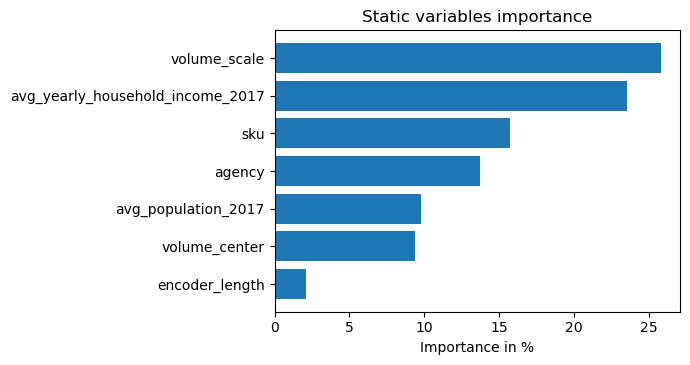

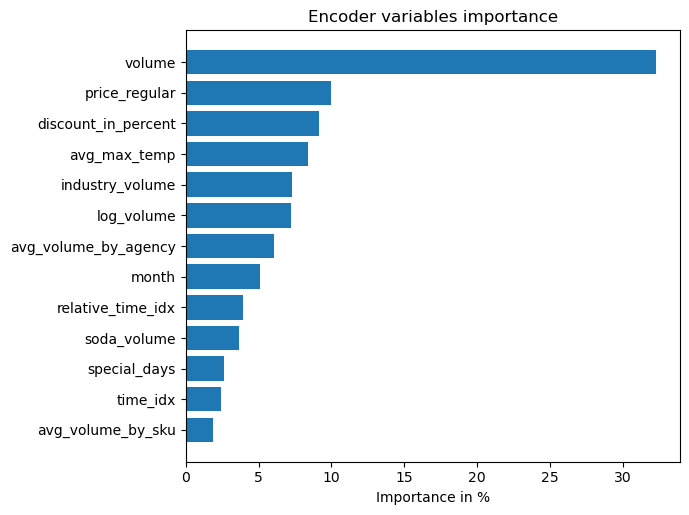

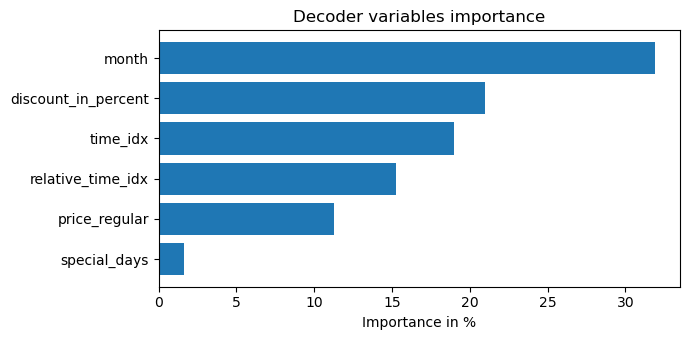

In [87]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum") ## aggregate to required levels 
best_tft.plot_interpretation(interpretation)

### Partial dependency

In [88]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

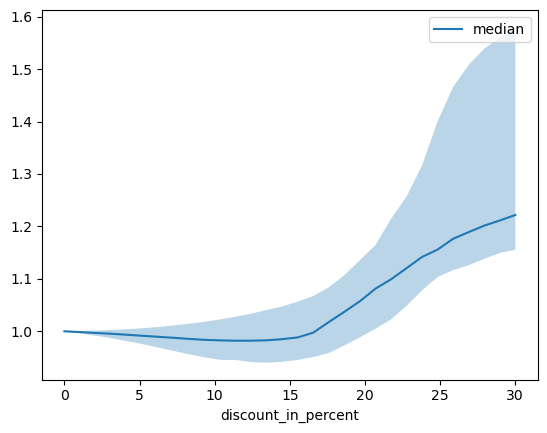

In [89]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);